In [1]:
import numpy as np
import os 
import itertools 
import uproot
import awkward as ak
import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, BaseSchema
from coffea.analysis_tools import Weights
from ntuple_schema import NtupleSchema, NtupleSchemaData
import hist
import vector
vector.register_awkward()
from dask_jobqueue import SLURMCluster
from distributed import Client
import pickle

import mplhep as hep
hep.style.use([hep.style.ATLAS])
import matplotlib.pyplot as plt

GeV = 1000

In [2]:
luminosity = 2478.52 #pb-1

In [3]:
file_path = "/gpfs/slac/atlas/fs1/d/recsmith/aswt_samples/"

In [4]:
MC_refdict = { 
    
    #Up-type Signals, electron channel
    "sig_el_LQu_700": { 
        "long_name": "LQu Signal, 700 GeV el",
        "ntup_filenames": {
            "output_312261/": {"DSID": 312261, "xsec": 7.30E-02, "kfactor": 1.0},
        },
        "subdir": "signal/",
        "plt_color": "red",
    },
    
    #Zee + jets
    "zjets": { 
        "long_name": "Zee+jets",
        "ntup_filenames": {
            "output_700320/": {"DSID": 700320, "xsec": 55.5413852,  "kfactor": 1.0},
            "output_700321/": {"DSID": 700321, "xsec": 286.392209,  "kfactor": 1.0},
            "output_700322/": {"DSID": 700322, "xsec": 1879.375291, "kfactor": 1.0},
        },
        "subdir": "zjets/",
        "plt_color": "lightskyblue",
    },
    
    #ttbar
    "ttbar": { 
        "long_name": "ttbar",
        "ntup_filenames": {
            "output_410472/": {"DSID": 410472, "xsec": 76.95,  "kfactor": 1.1398},
        },
        "subdir": "ttbar/",
        "plt_color": "forestgreen",
    },
    
    #Wev + jets
    #"wjets": { 
    #    "long_name": "Wev+jets",
    #    "ntup_filenames": {
    #        "output_700338/": {"DSID": 700338, "xsec": 204.4487228, "kfactor": 1.0},
    #        "output_700339/": {"DSID": 700339, "xsec": 3194.76948,  "kfactor": 1.0},
    #        "output_700340/": {"DSID": 700340, "xsec": 18342.85572, "kfactor": 1.0},
    #    },
    #    "subdir": "wjets/",
    #    "plt_color": "darkgoldenrod",
    #},
    
    #diboson
    #"diboson": { 
    #    "long_name": "Diboson",
    #    "ntup_filenames": {
    #        "output_363356/": {"DSID": 363356, "xsec": 15.563,  "kfactor": 0.13961},
    #        "output_363358/": {"DSID": 363358, "xsec": 3.437,   "kfactor": 1.0},
    #        "output_364250/": {"DSID": 364250, "xsec": 1.2523,  "kfactor": 1.0},
    #        "output_364253/": {"DSID": 364253, "xsec": 4.5832,  "kfactor": 1.0},
    #        "output_364254/": {"DSID": 364254, "xsec": 12.501,  "kfactor": 1.0},
    #    },
    #    "subdir": "diboson/",
    #    "plt_color": "darkgray",
    #},
    
    #singletop
    #"singletop": { 
    #    "long_name": "Single Top",
    #    "ntup_filenames": {
    #        "output_410644/": {"DSID": 410644, "xsec": 2.0268,  "kfactor": 1.015},
    #        "output_410645/": {"DSID": 410645, "xsec": 1.2676,  "kfactor": 1.015},
    #        "output_410648/": {"DSID": 410648, "xsec": 3.9968,  "kfactor": 0.945},
    #        "output_410649/": {"DSID": 410649, "xsec": 3.9940,  "kfactor": 0.946},
    #        "output_410658/": {"DSID": 410658, "xsec": 36.993,  "kfactor": 1.191},
    #        "output_410659/": {"DSID": 410659, "xsec": 22.175,  "kfactor": 1.183},
    #    },
    #    "subdir": "singletop/",
    #    "plt_color": "royalblue",
    #},
    
    
}

In [5]:
DATA_refdict = { 
    
    #data
    "data": { 
        "long_name": "Data",
        "ntup_filenames": {
            "output_00340030/": {"DSID": 999999, "xsec": 1.0, "kfactor": 1.0},
            "output_00340072/": {"DSID": 999999, "xsec": 1.0, "kfactor": 1.0},
            "output_00340368/": {"DSID": 999999, "xsec": 1.0, "kfactor": 1.0},
            "output_00340453/": {"DSID": 999999, "xsec": 1.0, "kfactor": 1.0},
        },
        "subdir": "data/",
        "plt_color": "black",
    },
}

In [6]:
# Note the new preselection applied in our processor! 

class MyProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.axis.StrCategory(name="d_axis", label="", categories=[], growth=True)
        dielec_mass_axis = hist.axis.Regular(name="e_axis", label="$e\\bar{e}$ mass [GeV]", bins=50, start=0, stop=1000)
        
        #edges = [500,600,700,800,900,1000,1200,1500,2000]
        #mlq_avg_axis = hist.axis.Variable(edges, name="m_axis", label=r"Avg. $m_{\ell j}$ [GeV]")
        mlq_avg_axis = hist.axis.Regular(name="m_axis", label=r"Avg. $m_{\ell j}$ [GeV]", bins=25, start=200, stop=1200)

        
        self.output = {
            'h_dielec_mass':  hist.Hist(dataset_axis, dielec_mass_axis) , 
            'h_mlq_avg':      hist.Hist(dataset_axis, mlq_avg_axis) , 
        }
    
    def process(self, events):
                
        elec = events.Electron
        muon = events.Muon
        jet = events.Jet
        met = events.MET

        dielec_neutral = ( 
            (ak.num(elec) == 2) &                     # We want exactly two electrons 
            (ak.sum(elec.charge, axis=1) == 0) &      # We want our electrons to have opposite charge 
            (ak.num(muon) == 0) &                     # We want no muons
            (ak.num(jet) >= 2 )                       # We also need at least two jets 
        )

        # Apply the electron-and-jet-level preselection (two electrons and two+ jets with pT cuts)
        obj_presel = ( 
            (elec[dielec_neutral,0].pt/GeV >= 27 ) &     # We want our two electrons to have a pT >= 27 GeV 
            (elec[dielec_neutral,1].pt/GeV >= 27 ) & 
            (jet[dielec_neutral,0].pt/GeV >= 45 ) &      # Our jets should have a pT = 45 GeV
            (jet[dielec_neutral,1].pt/GeV >= 45 ) & 
            (jet[dielec_neutral,0].eta <= 2.5 ) &        # Our jets should have an eta <= 2.5 ("central" jet) 
            (jet[dielec_neutral,1].eta <= 2.5 )             
        )
        
        # This time, let's save the MET Significance, too 
        # This is a bit more complicated to calculate, but it's just the MET divided by the scalar sum of the e and j pTs 
        met_sig = (
            met[dielec_neutral][obj_presel].sumet[:,-1] / np.sqrt( 
                np.sum( 
                    [np.sum(elec[dielec_neutral][obj_presel,:].pt,axis=1),
                    np.sum(jet[dielec_neutral][obj_presel,:2].pt,axis=1)],axis=0  # only want the leading two jets
                )
            )
        )
        
        # Again, let's save the di-electron mass 
        dielec_mass = (elec[dielec_neutral][obj_presel,0] + elec[dielec_neutral][obj_presel,1]).mass
        dielec_pt = (elec[dielec_neutral][obj_presel,0] + elec[dielec_neutral][obj_presel,1]).pt
  
        # We next reconstruct the m_lq values for all lepton-jet pairs 
        # Note that we'll only use the two "leading" jets in pT (those with the highest pT) 
        pairs = ak.cartesian( {'e':elec[dielec_neutral][obj_presel], 'j':jet[dielec_neutral][obj_presel,:2]} ) 
        mlq = ( pairs.e + pairs.j ).mass
        
        # We only have two options for uniquely pairing 2 electrons with 2 jets, so we can define these explicitly below 
        pair_opt_1 = ak.zip( {
            'm1':( elec[dielec_neutral][obj_presel,0] + jet[dielec_neutral][obj_presel,0] ).mass , 
            'm2':( elec[dielec_neutral][obj_presel,1] + jet[dielec_neutral][obj_presel,1] ).mass
        } ) 
        pair_opt_2 = ak.zip( {
            'm1':( elec[dielec_neutral][obj_presel,0] + jet[dielec_neutral][obj_presel,1] ).mass , 
            'm2':( elec[dielec_neutral][obj_presel,1] + jet[dielec_neutral][obj_presel,0] ).mass
        } ) 
        
        # Get the e-j mass system difference from each of our pairing configurations 
        mdiff1 = np.abs( pair_opt_1.m1 - pair_opt_1.m2 )
        mdiff2 = np.abs( pair_opt_2.m1 - pair_opt_2.m2 )
        
        # Store the pair with the smallest mass difference between the e-j pairs 
        closest_pairs = ak.where( (mdiff1 < mdiff2) , pair_opt_1 , pair_opt_2 )
        mlq1,mlq2 = ak.unzip(closest_pairs)
        
        # Essentially separate the mass values into the larger and the smaller values 
        mlq_max = ak.where( (mlq1 > mlq2) , mlq1 , mlq2 )
        mlq_min = ak.where( (mlq1 < mlq2) , mlq1 , mlq2 )
        
        # Calculate some useful variables, like average m_lq and the m_lq asymmetry 
        mlq_avg = 0.5*(mlq_min+mlq_max)
        mlq_asym = ( mlq_max - mlq_min ) / ( mlq_min + mlq_max )

        # Now we can calculate the full preselection with event-level variables 
        # Note that we applied the object (electron and jet) level selection first, since we need those objects 
        # in order to calculate the event level variables below 
        evt_presel = (
            # The MET Significance should be < 3.5 GeV
            ( met_sig < 1000*GeV ) & 
            # Our dilepton system should have a pT > 75 GeV
            ( dielec_pt > 75*GeV ) &
            # Our dilepton system should have a mass > 130 GeV
            ( dielec_mass > 130*GeV )             
        )  
        
        events_selection = events[dielec_neutral][obj_presel][evt_presel]
        weights = Weights(len(events_selection))
        if events.metadata["sum_of_weights"][0]!=1.0:
            weights.add(
                "genWeight", 
                events_selection.weight * events.metadata["xsec"][0] * events.metadata["kfactor"][0] * \
                events.metadata["luminosity"][0] / events.metadata["sum_of_weights"][0]
            )

        dataset = events.metadata['dataset']
        self.output['h_dielec_mass'].fill(d_axis=dataset, e_axis=dielec_mass[evt_presel]/GeV, weight=weights.weight())
        self.output['h_mlq_avg'].fill(d_axis=dataset, m_axis=mlq_avg[evt_presel]/GeV, weight=weights.weight())
    
        return self.output
    
    def postprocess(self, accumulator):
        pass

In [7]:
"""
myhists = {}

for key in MC_refdict: 
    
    myhists[ MC_refdict[key]['long_name'] ] = {}
    print(MC_refdict[key]['long_name'])
    
    for filename in MC_refdict[key]['ntup_filenames']: 
        print("  " + filename)
        
        myhists[ MC_refdict[key]['long_name'] ][filename] = {'total_events': 0, 'sum_of_weights': 0}
        
        file_loc = f"{file_path}/{MC_refdict[key]['subdir']}/{filename}/"
        subfiles = os.listdir(file_loc)
        
        for i,subfile in enumerate(subfiles):
            if i%50==0:
                print("    Evaluating {}/{} subfiles".format(i,len(subfiles)))
            
            if("DAOD_PHYS" not in subfile): continue
            if( os.path.getsize(f"{file_loc}/{subfile}") == 0 ): continue   # skip empty files
            
            file = uproot.open(f"{file_loc}/{subfile}/hist-sample.root")
            
            myhists[ MC_refdict[key]['long_name'] ][filename]['total_events'] += file["CutBookkeeper_{}_284500_NOSYS".format(
                MC_refdict[key]['ntup_filenames'][filename]['DSID'])].values()[0]
            myhists[ MC_refdict[key]['long_name'] ][filename]['sum_of_weights'] += file["CutBookkeeper_{}_284500_NOSYS".format(
                MC_refdict[key]['ntup_filenames'][filename]['DSID'])].values()[1]
"""

'\nmyhists = {}\n\nfor key in MC_refdict: \n    \n    myhists[ MC_refdict[key][\'long_name\'] ] = {}\n    print(MC_refdict[key][\'long_name\'])\n    \n    for filename in MC_refdict[key][\'ntup_filenames\']: \n        print("  " + filename)\n        \n        myhists[ MC_refdict[key][\'long_name\'] ][filename] = {\'total_events\': 0, \'sum_of_weights\': 0}\n        \n        file_loc = f"{file_path}/{MC_refdict[key][\'subdir\']}/{filename}/"\n        subfiles = os.listdir(file_loc)\n        \n        for i,subfile in enumerate(subfiles):\n            if i%50==0:\n                print("    Evaluating {}/{} subfiles".format(i,len(subfiles)))\n            \n            if("DAOD_PHYS" not in subfile): continue\n            if( os.path.getsize(f"{file_loc}/{subfile}") == 0 ): continue   # skip empty files\n            \n            file = uproot.open(f"{file_loc}/{subfile}/hist-sample.root")\n            \n            myhists[ MC_refdict[key][\'long_name\'] ][filename][\'total_events\'] +=

In [8]:
#with open('weights_dictionary.pkl', 'wb') as f:
#    pickle.dump(myhists, f)
    
with open('weights_dictionary.pkl', 'rb') as f:
    myhists = pickle.load(f)

In [9]:
myhists

{'LQu Signal, 700 GeV el': {'output_312261/': {'total_events': 60000.0,
   'sum_of_weights': 3821.805419921875}},
 'Zee+jets': {'output_700320/': {'total_events': 4570000.0,
   'sum_of_weights': 14723979634688.0},
  'output_700321/': {'total_events': 8362000.0,
   'sum_of_weights': 58215029334016.0},
  'output_700322/': {'total_events': 8245000.0,
   'sum_of_weights': 115449552338944.0}},
 'ttbar': {'output_410472/': {'total_events': 98207000.0,
   'sum_of_weights': 71709103836.0}},
 'Wev+jets': {'output_700338/': {'total_events': 4710000.0,
   'sum_of_weights': 134521319227392.0},
  'output_700339/': {'total_events': 8928000.0,
   'sum_of_weights': 680694726787072.0},
  'output_700340/': {'total_events': 28928000.0,
   'sum_of_weights': 4711297710030848.0}},
 'Diboson': {'output_363356/': {'total_events': 5400000.0,
   'sum_of_weights': 3493067.3330078125},
  'output_363358/': {'total_events': 26911000.0,
   'sum_of_weights': 1267165.2700805664},
  'output_364250/': {'total_events': 3

In [10]:
my_MC_files = {}

for key in MC_refdict: 
    
    my_MC_files[ MC_refdict[key]['long_name'] ] = {}
    my_MC_files[ MC_refdict[key]['long_name'] ]['files'] = []
    my_MC_files[ MC_refdict[key]['long_name'] ]['metadata'] = {
        'xsec': [], 'kfactor': [], 'sum_of_weights': [], 'luminosity': []
    }
    
    for filename in MC_refdict[key]['ntup_filenames']: 
        
        file_loc = f"{file_path}/{MC_refdict[key]['subdir']}/{filename}/"
        subfiles = os.listdir(file_loc)
        
        for subfile in subfiles:
            
            if("DAOD_PHYS" not in subfile): continue
            if( os.path.getsize(f"{file_loc}/{subfile}") == 0 ): continue   # skip empty files
                
            my_MC_files[ MC_refdict[key]['long_name'] ]['files'].append( f"{file_loc}/{subfile}/data-ANALYSIS/sample.root" ) 
            
            my_MC_files[ MC_refdict[key]['long_name'] ]['metadata']['xsec'].append( 
                MC_refdict[key]['ntup_filenames'][filename]['xsec'] 
            ) 
            my_MC_files[ MC_refdict[key]['long_name'] ]['metadata']['kfactor'].append( 
                MC_refdict[key]['ntup_filenames'][filename]['kfactor'] 
            )
            my_MC_files[ MC_refdict[key]['long_name'] ]['metadata']['luminosity'].append( 
                luminosity
            )
            my_MC_files[ MC_refdict[key]['long_name'] ]['metadata']['sum_of_weights'].append( 
                myhists[ MC_refdict[key]['long_name'] ][filename]['sum_of_weights'] 
            )

In [11]:
my_DATA_files = {}

for key in DATA_refdict: 
    
    my_DATA_files[ DATA_refdict[key]['long_name'] ] = {}
    my_DATA_files[ DATA_refdict[key]['long_name'] ]['files'] = []
    my_DATA_files[ DATA_refdict[key]['long_name'] ]['metadata'] = {
        'xsec': [], 'kfactor': [], 'sum_of_weights': [], 'luminosity': []
    }
    
    for filename in DATA_refdict[key]['ntup_filenames']: 
        
        file_loc = f"{file_path}/{DATA_refdict[key]['subdir']}/{filename}/"
        subfiles = os.listdir(file_loc)
        
        for subfile in subfiles:
            
            if("DAOD_PHYS" not in subfile): continue
            if( os.path.getsize(f"{file_loc}/{subfile}") == 0 ): continue   # skip empty files
            if( os.path.getsize(f"{file_loc}/{subfile}/data-ANALYSIS/sample.root") < 1000 ): 
                print(f"{file_loc}/{subfile}/data-ANALYSIS/sample.root")
                continue   # skip empty files
                
            my_DATA_files[ DATA_refdict[key]['long_name'] ]['files'].append( f"{file_loc}/{subfile}/data-ANALYSIS/sample.root" ) 
            
            my_DATA_files[ DATA_refdict[key]['long_name'] ]['metadata']['xsec'].append(1.0) 
            my_DATA_files[ DATA_refdict[key]['long_name'] ]['metadata']['kfactor'].append(1.0)
            my_DATA_files[ DATA_refdict[key]['long_name'] ]['metadata']['luminosity'].append(1.0)
            my_DATA_files[ DATA_refdict[key]['long_name'] ]['metadata']['sum_of_weights'].append(1.0)

/gpfs/slac/atlas/fs1/d/recsmith/aswt_samples//data//output_00340072///DAOD_PHYS_28105679__001416/data-ANALYSIS/sample.root
/gpfs/slac/atlas/fs1/d/recsmith/aswt_samples//data//output_00340072///DAOD_PHYS_28105679__001618/data-ANALYSIS/sample.root
/gpfs/slac/atlas/fs1/d/recsmith/aswt_samples//data//output_00340072///DAOD_PHYS_28105679__001414/data-ANALYSIS/sample.root
/gpfs/slac/atlas/fs1/d/recsmith/aswt_samples//data//output_00340072///DAOD_PHYS_28105679__001584/data-ANALYSIS/sample.root
/gpfs/slac/atlas/fs1/d/recsmith/aswt_samples//data//output_00340072///DAOD_PHYS_28105679__001586/data-ANALYSIS/sample.root
/gpfs/slac/atlas/fs1/d/recsmith/aswt_samples//data//output_00340072///DAOD_PHYS_28105679__001754/data-ANALYSIS/sample.root
/gpfs/slac/atlas/fs1/d/recsmith/aswt_samples//data//output_00340072///DAOD_PHYS_28105679__001763/data-ANALYSIS/sample.root
/gpfs/slac/atlas/fs1/d/recsmith/aswt_samples//data//output_00340072///DAOD_PHYS_28105679__001587/data-ANALYSIS/sample.root
/gpfs/slac/atlas

In [12]:
myfile = "/gpfs/slac/atlas/fs1/d/recsmith/aswt_samples//diboson//output_363358///DAOD_PHYS_28119611__001635/data-ANALYSIS/sample.root"
events = NanoEventsFactory.from_root(
    myfile, "analysis", metadata={"dataset": "Z+jets", "sum_of_weights":[1.0]}, schemaclass=NtupleSchema,
    entry_stop = 500
).events()
out = MyProcessor().process(events)

In [13]:
cluster = SLURMCluster(
    queue='shared',
    project="analysis",
    cores=10,
    memory="750 GB",
    python="/gpfs/slac/atlas/fs1/d/recsmith/miniconda/envs/aswt_env/bin/python3.10",
    job_extra_directives=['--account=shared', '--partition=shared', '--output=/dev/null', '--error=/dev/null'],
)
cluster.scale(jobs=100)  # ask for 20 jobs

In [14]:
client = Client(cluster)

In [15]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://134.79.20.123:8787/status,
Dashboard: http://134.79.20.123:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://134.79.20.123:36902,Workers: 0
Dashboard: http://134.79.20.123:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [16]:
executor = processor.DaskExecutor(client=client, compression=None)
run = processor.Runner(
    executor=executor,
    schema=NtupleSchema,
)
out_MC = run(my_MC_files, "analysis", processor_instance=MyProcessor())

In [17]:
out_MC

{'h_dielec_mass': Hist(
   StrCategory(['ttbar', 'Zee+jets', 'LQu Signal, 700 GeV el'], growth=True, name='d_axis'),
   Regular(50, 0, 1000, name='e_axis', label='$e\\bar{e}$ mass [GeV]'),
   storage=Double()) # Sum: 2272.3700126337744 (2279.8870184372795 with flow),
 'h_mlq_avg': Hist(
   StrCategory(['ttbar', 'Zee+jets', 'LQu Signal, 700 GeV el'], growth=True, name='d_axis'),
   Regular(25, 200, 1200, name='m_axis', label='Avg. $m_{\\ell j}$ [GeV]'),
   storage=Double()) # Sum: 691.8182726219376 (2279.8870184372795 with flow)}

In [18]:
executor = processor.DaskExecutor(client=client, compression=None)
run = processor.Runner(
    executor=executor,
    schema=NtupleSchemaData,
)
out_DATA = run(my_DATA_files, "analysis", processor_instance=MyProcessor())

In [19]:
out_DATA

{'h_dielec_mass': Hist(
   StrCategory(['Data'], growth=True, name='d_axis'),
   Regular(50, 0, 1000, name='e_axis', label='$e\\bar{e}$ mass [GeV]'),
   storage=Double()) # Sum: 3410.0 (3418.0 with flow),
 'h_mlq_avg': Hist(
   StrCategory(['Data'], growth=True, name='d_axis'),
   Regular(25, 200, 1200, name='m_axis', label='Avg. $m_{\\ell j}$ [GeV]'),
   storage=Double()) # Sum: 1079.0 (3418.0 with flow)}

In [20]:
#cluster.close()

In [21]:
MC_refdict.keys()

dict_keys(['sig_el_LQu_700', 'zjets', 'ttbar'])

In [22]:
mycolorlist = [ MC_refdict[key]['plt_color'] for key in MC_refdict.keys() ]
mycolorlist.reverse()

In [23]:
mycolorlist

['forestgreen', 'lightskyblue', 'red']

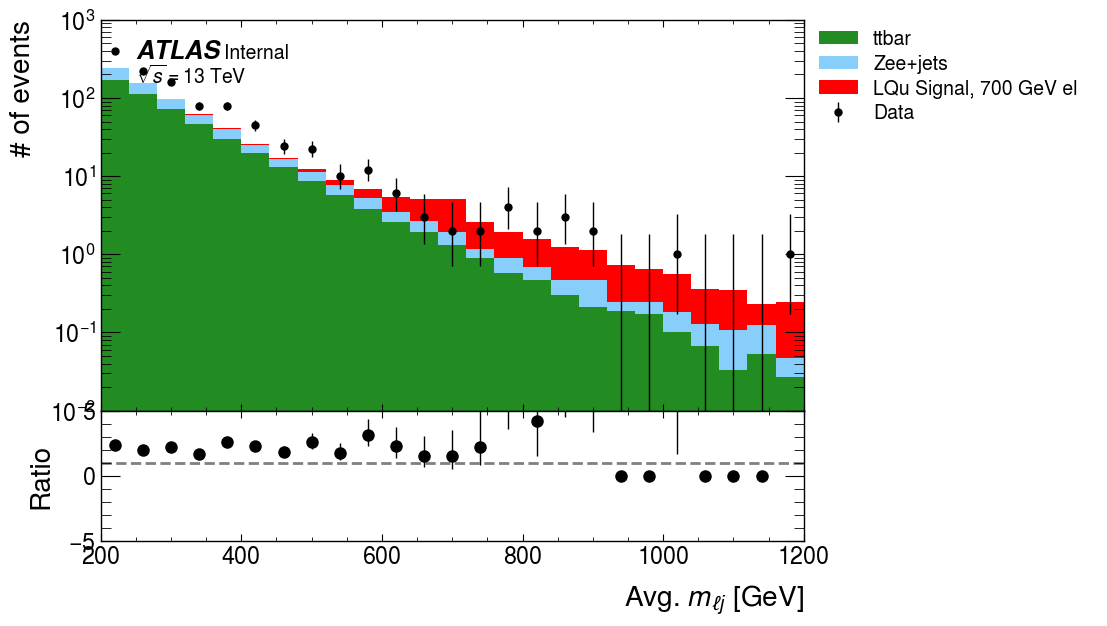

In [26]:
# Plotting the m_lq average

fig, (ax, rax) = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[3, 1], hspace=0), sharex=True)
fig.tight_layout()
#fig, ax = plt.subplots(1, figsize=(6, 4), dpi=100)
    
out_MC["h_mlq_avg"].plot1d(ax=ax, color=mycolorlist, stack=True, histtype="fill") 
out_DATA["h_mlq_avg"].plot1d(ax=ax, color="black", histtype="errorbar") 

from hist.intervals import ratio_uncertainty
rax.errorbar(
    x=out_DATA["h_mlq_avg"].axes[1].centers,
    y=out_DATA["h_mlq_avg"].view()[0] / out_MC["h_mlq_avg"].view()[0],
    yerr=ratio_uncertainty(out_DATA["h_mlq_avg"].view()[0], out_MC["h_mlq_avg"].view()[0], "poisson"),
    color="k",
    linestyle="none",
    marker="o",
    elinewidth=1,
)
rax.axhline(y=1.0, linestyle="dashed", color="gray")
rax.set_ylabel("Ratio", loc="center")
rax.set_ylim(-5, 5)
rax.set_xlabel("Avg. $m_{\ell j}$ [GeV]")

hep.atlas.label(ax=ax, data=True, label="Internal")

ax.legend(bbox_to_anchor=(0.98, 1.05), loc="upper left")

ax.set_ylabel('# of events')
ax.set_yscale("log")
plt.show()